In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import random
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F
import math
import time

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def no_of_params(model):
    sum_ = 0.
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [24]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_5/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_5/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float32)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = torch.tensor( [Y[0][1], Y[0][2]] , dtype=torch.float32)
            #Y = Y[1][0]/3.1415926
            #Y = Y - 0.5
            
            #Y = torch.tensor( Y, dtype=torch.float32 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y
    
all_ids = [str(i) for i in  list(np.arange(0,10000,1))]
#train_ids = all_ids[:8000]
#val_ids   = all_ids[8000:]#1000]

train_ids = all_ids[:800]
val_ids   = all_ids[800:1000]#1000]

params = {
    'batch_size'  : 8,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

In [27]:
batch[1].shape

torch.Size([8, 2])

tensor([[-0.1081,  0.5303],
        [ 0.1469, -0.4054],
        [-0.0442, -0.0580],
        [-0.6188, -0.4840],
        [ 0.5848,  0.1971],
        [ 0.8731, -0.6602],
        [-0.5301, -0.7490],
        [ 0.3273, -0.4987]])

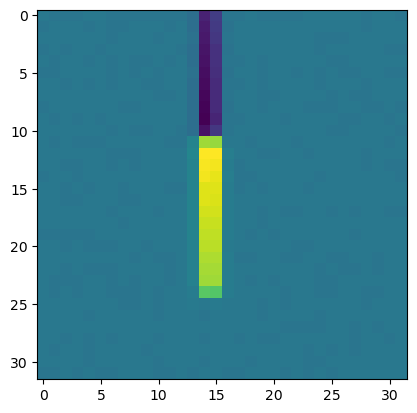

In [31]:
for batch in training_generator:
    break

plt.imshow(batch[0][0][0])
batch[1]

In [19]:
def train_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [34]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1  = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=1)
        self.bn1    = nn.BatchNorm2d(8)
        self.conv2  = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.bn2    = nn.BatchNorm2d(16)
        self.pool   = nn.MaxPool2d(2,2)
        self.conv4  = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.bn4    = nn.BatchNorm2d(32)
        self.conv5  = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.bn5    = nn.BatchNorm2d(64)
        self.fc1    = nn.Linear(64*10*10, 2)

    def forward(self, input):
        output = torch.tanh(self.bn1(self.conv1(input)))      
        output = torch.tanh(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = torch.tanh(self.bn4(self.conv4(output)))     
        output = torch.tanh(self.bn5(self.conv5(output))) 
        #print(output.shape)
        output = output.view(-1, 64*10*10)
        output = self.fc1(output)
        output = torch.tanh(output)

        return output

torch.set_default_tensor_type(torch.FloatTensor)
model = Network()
no_of_params(model)

80806

In [ ]:
lr = 3e-7
wd = 1e-3
model = Network()

epochs = 2000
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd,
    )

gamma = 0.998
scheduler = lr_scheduler.ExponentialLR(
    optimizer, 
    gamma     = gamma)

train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    #optimizer.step()
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,6), " Val loss: ",round(val_loss,6), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

EPOCH:  1  Train loss:  0.324088  Val loss:  0.252114  LR:  2.994e-07
EPOCH:  2  Train loss:  0.252654  Val loss:  0.188879  LR:  2.988e-07
EPOCH:  3  Train loss:  0.190097  Val loss:  0.138585  LR:  2.982e-07
EPOCH:  4  Train loss:  0.141067  Val loss:  0.101903  LR:  2.976e-07
EPOCH:  5  Train loss:  0.105255  Val loss:  0.076424  LR:  2.97e-07
EPOCH:  6  Train loss:  0.082082  Val loss:  0.059415  LR:  2.964e-07
EPOCH:  7  Train loss:  0.065481  Val loss:  0.048578  LR:  2.958e-07
EPOCH:  8  Train loss:  0.051987  Val loss:  0.042747  LR:  2.952e-07
EPOCH:  9  Train loss:  0.045283  Val loss:  0.041871  LR:  2.946e-07
EPOCH:  10  Train loss:  0.044436  Val loss:  0.038939  LR:  2.941e-07
EPOCH:  11  Train loss:  0.042004  Val loss:  0.041236  LR:  2.935e-07
EPOCH:  12  Train loss:  0.043494  Val loss:  0.041263  LR:  2.929e-07
EPOCH:  13  Train loss:  0.045871  Val loss:  0.044129  LR:  2.923e-07
EPOCH:  14  Train loss:  0.048711  Val loss:  0.047394  LR:  2.917e-07
EPOCH:  15  Trai

EPOCH:  117  Train loss:  0.010874  Val loss:  0.010317  LR:  2.374e-07
EPOCH:  118  Train loss:  0.010904  Val loss:  0.009594  LR:  2.369e-07
EPOCH:  119  Train loss:  0.010771  Val loss:  0.009923  LR:  2.364e-07
EPOCH:  120  Train loss:  0.010892  Val loss:  0.009177  LR:  2.359e-07
EPOCH:  121  Train loss:  0.010335  Val loss:  0.009759  LR:  2.355e-07
EPOCH:  122  Train loss:  0.010495  Val loss:  0.008906  LR:  2.35e-07
EPOCH:  123  Train loss:  0.010096  Val loss:  0.008824  LR:  2.345e-07
EPOCH:  124  Train loss:  0.010028  Val loss:  0.009025  LR:  2.34e-07
EPOCH:  125  Train loss:  0.010001  Val loss:  0.008533  LR:  2.336e-07
EPOCH:  126  Train loss:  0.00992  Val loss:  0.008366  LR:  2.331e-07
EPOCH:  127  Train loss:  0.009642  Val loss:  0.009333  LR:  2.326e-07
EPOCH:  128  Train loss:  0.009362  Val loss:  0.008137  LR:  2.322e-07
EPOCH:  129  Train loss:  0.009535  Val loss:  0.008112  LR:  2.317e-07
EPOCH:  130  Train loss:  0.009189  Val loss:  0.008069  LR:  2.313

EPOCH:  232  Train loss:  0.003125  Val loss:  0.002935  LR:  1.885e-07
EPOCH:  233  Train loss:  0.003012  Val loss:  0.002999  LR:  1.882e-07
EPOCH:  234  Train loss:  0.003084  Val loss:  0.002972  LR:  1.878e-07
EPOCH:  235  Train loss:  0.003001  Val loss:  0.002914  LR:  1.874e-07
EPOCH:  236  Train loss:  0.003009  Val loss:  0.002928  LR:  1.87e-07
EPOCH:  237  Train loss:  0.003256  Val loss:  0.002929  LR:  1.867e-07
EPOCH:  238  Train loss:  0.00301  Val loss:  0.002927  LR:  1.863e-07
EPOCH:  239  Train loss:  0.003095  Val loss:  0.002881  LR:  1.859e-07
EPOCH:  240  Train loss:  0.003024  Val loss:  0.002883  LR:  1.855e-07
EPOCH:  241  Train loss:  0.00293  Val loss:  0.0029  LR:  1.852e-07
EPOCH:  242  Train loss:  0.002871  Val loss:  0.002902  LR:  1.848e-07
EPOCH:  243  Train loss:  0.002787  Val loss:  0.00285  LR:  1.844e-07
EPOCH:  244  Train loss:  0.00301  Val loss:  0.002857  LR:  1.841e-07
EPOCH:  245  Train loss:  0.002889  Val loss:  0.002825  LR:  1.837e-07

EPOCH:  347  Train loss:  0.002067  Val loss:  0.002073  LR:  1.498e-07
EPOCH:  348  Train loss:  0.002026  Val loss:  0.002062  LR:  1.495e-07
EPOCH:  349  Train loss:  0.001965  Val loss:  0.002086  LR:  1.492e-07
EPOCH:  350  Train loss:  0.001963  Val loss:  0.002006  LR:  1.489e-07
EPOCH:  351  Train loss:  0.001842  Val loss:  0.002045  LR:  1.486e-07
EPOCH:  352  Train loss:  0.001882  Val loss:  0.002012  LR:  1.483e-07
EPOCH:  353  Train loss:  0.001917  Val loss:  0.002016  LR:  1.48e-07
EPOCH:  354  Train loss:  0.001955  Val loss:  0.001998  LR:  1.477e-07
EPOCH:  355  Train loss:  0.001873  Val loss:  0.002007  LR:  1.474e-07
EPOCH:  356  Train loss:  0.001936  Val loss:  0.002003  LR:  1.471e-07
EPOCH:  357  Train loss:  0.001841  Val loss:  0.002023  LR:  1.468e-07
EPOCH:  358  Train loss:  0.001872  Val loss:  0.001964  LR:  1.465e-07
EPOCH:  359  Train loss:  0.001764  Val loss:  0.001937  LR:  1.462e-07
EPOCH:  360  Train loss:  0.001856  Val loss:  0.001966  LR:  1.4

EPOCH:  462  Train loss:  0.001551  Val loss:  0.00152  LR:  1.19e-07
EPOCH:  463  Train loss:  0.001636  Val loss:  0.001524  LR:  1.187e-07
EPOCH:  464  Train loss:  0.001495  Val loss:  0.001532  LR:  1.185e-07
EPOCH:  465  Train loss:  0.001512  Val loss:  0.001456  LR:  1.183e-07
EPOCH:  466  Train loss:  0.001494  Val loss:  0.001421  LR:  1.18e-07
EPOCH:  467  Train loss:  0.001502  Val loss:  0.001459  LR:  1.178e-07
EPOCH:  468  Train loss:  0.001498  Val loss:  0.001416  LR:  1.175e-07
EPOCH:  469  Train loss:  0.001512  Val loss:  0.001458  LR:  1.173e-07
EPOCH:  470  Train loss:  0.001563  Val loss:  0.001411  LR:  1.171e-07
EPOCH:  471  Train loss:  0.001516  Val loss:  0.001361  LR:  1.168e-07
EPOCH:  472  Train loss:  0.001483  Val loss:  0.001342  LR:  1.166e-07
EPOCH:  473  Train loss:  0.001563  Val loss:  0.001382  LR:  1.164e-07
EPOCH:  474  Train loss:  0.001422  Val loss:  0.00139  LR:  1.161e-07
EPOCH:  475  Train loss:  0.001521  Val loss:  0.001415  LR:  1.159e

EPOCH:  577  Train loss:  0.001394  Val loss:  0.001215  LR:  9.45e-08
EPOCH:  578  Train loss:  0.001331  Val loss:  0.001145  LR:  9.43e-08
EPOCH:  579  Train loss:  0.001318  Val loss:  0.001221  LR:  9.41e-08
EPOCH:  580  Train loss:  0.001266  Val loss:  0.00114  LR:  9.39e-08
EPOCH:  581  Train loss:  0.001436  Val loss:  0.001261  LR:  9.37e-08
EPOCH:  582  Train loss:  0.001236  Val loss:  0.001187  LR:  9.36e-08
EPOCH:  583  Train loss:  0.001297  Val loss:  0.001156  LR:  9.34e-08
EPOCH:  584  Train loss:  0.001363  Val loss:  0.001176  LR:  9.32e-08
EPOCH:  585  Train loss:  0.001349  Val loss:  0.001207  LR:  9.3e-08
EPOCH:  586  Train loss:  0.001213  Val loss:  0.001317  LR:  9.28e-08
EPOCH:  587  Train loss:  0.001299  Val loss:  0.001199  LR:  9.26e-08
EPOCH:  588  Train loss:  0.001279  Val loss:  0.001206  LR:  9.24e-08
EPOCH:  589  Train loss:  0.001204  Val loss:  0.001236  LR:  9.23e-08
EPOCH:  590  Train loss:  0.001337  Val loss:  0.001137  LR:  9.21e-08
EPOCH:  

In [ ]:
txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/8e-7 for lr in lrs ])
plt.show()

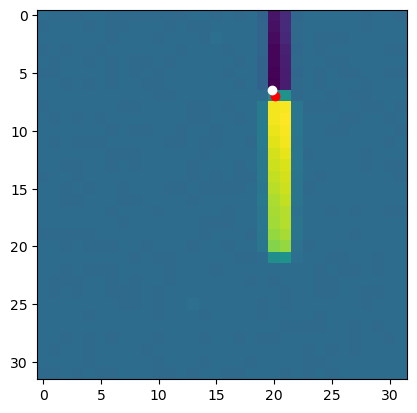

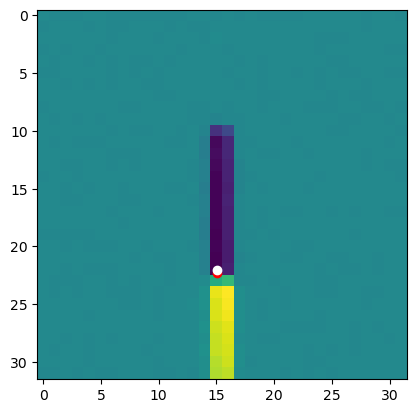

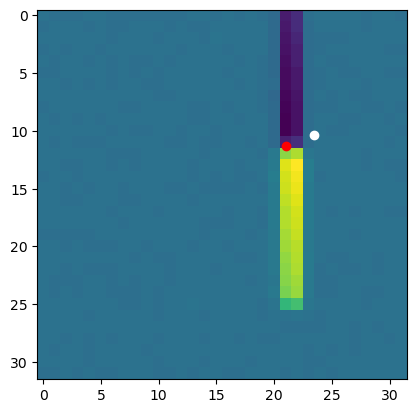

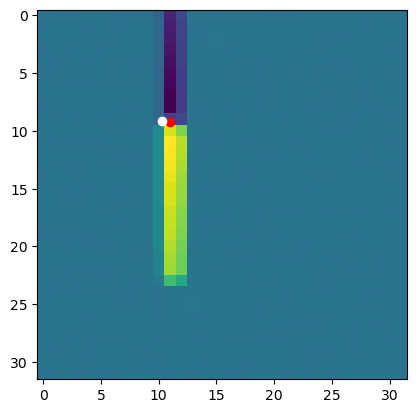

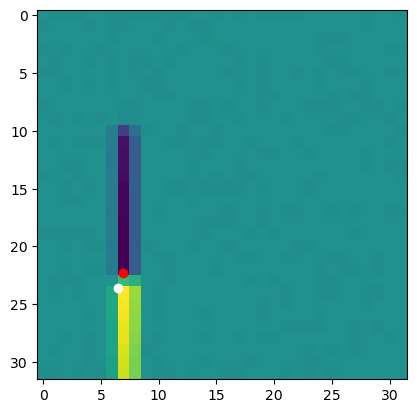

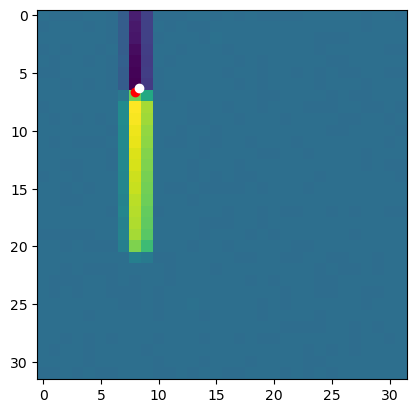

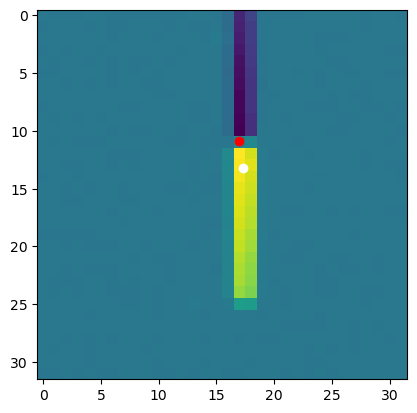

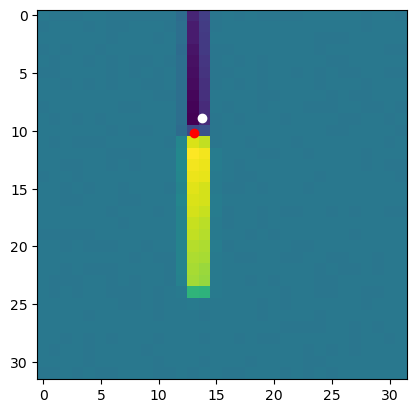

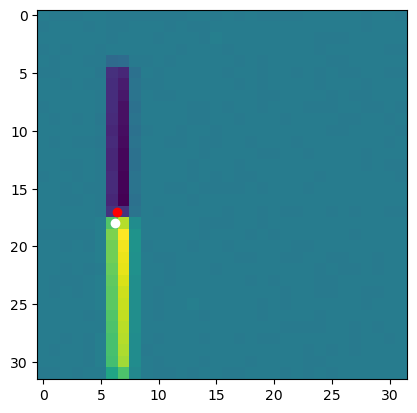

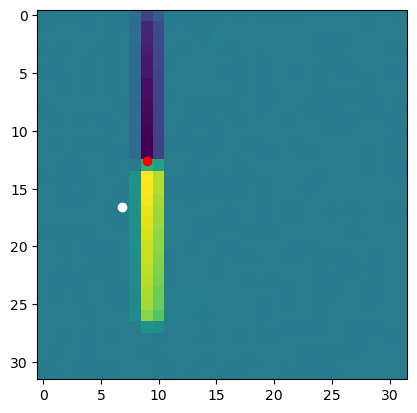

In [205]:
test_IDs = [ random.randint(0,999) for i in range(100) ]

real_x = []
real_y = []
outputs_x = []
outputs_y = []

for ID in test_IDs[:10]:
    input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_5/images/"
    label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_5/labels/"
    X = torchvision.io.read_image(
                input_dir + str(ID) + ".png "
            ).to(torch.float32)
    
    X = X/256.
    with open(label_dir + str(ID), 'rb') as fb:
        Y  = pickle.load(fb)
    output = model(X[1].unsqueeze(0).unsqueeze(0))

    plt.imshow(X[1])
    x = Y[0][1]
    y = Y[0][2]
    x = x*8.79 + 15.
    y = - y*8.79 + 15.
    
    x_ = float(output[0][0])
    y_ = float(output[0][1])
    x_ = x_*8.79 + 15.
    y_ = - y_*8.79 + 15.

    plt.plot(x,y, 'o', color='r')
    plt.plot(x_,y_, 'o', color='w')
    plt.show()
    

In [201]:
Y[0][1], Y[0][2]

(-0.02185716645603053, -0.2624940235265276)

In [198]:
float(output[0][0]),float(output[0][1])

tensor([ 0.3460, -0.2382], grad_fn=<SelectBackward0>)

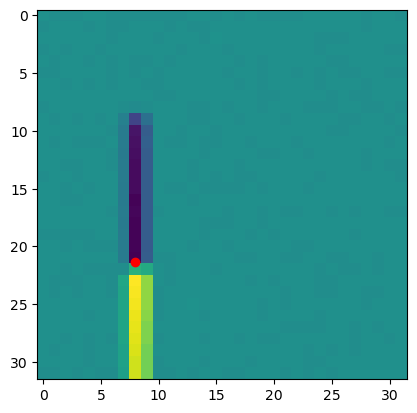

In [191]:
for batch in validation_generator:
    break
plt.imshow(batch[0][0][0])
x = float(batch[1][0][0])# + 1.
y = float(batch[1][0][1])# + 1.
x = x*8.79 + 15.
y = - y*8.79 + 15.
plt.plot(x,y, 'o', color='r')

In [194]:
model(batch[0])[0]

tensor([-0.9675, -0.9867], grad_fn=<SelectBackward0>)

In [112]:
x*8.79 + 16

35.47135445538163